In [170]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import seaborn as sns

mpl.rcParams["font.sans-serif"]=['Arial Unicode MS']
mpl.rcParams['axes.unicode_minus']=False


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import xgboost

import warnings
warnings.filterwarnings("ignore")

STEP 1,  准备数据集 （保险数据集）

In [175]:
insurance = pd.read_csv('/Users/mac/Documents/IvyLUE_DA/CDA/CDA业务数据可视化竞赛/保险数据集/保险数据_全部数据.csv')
insurance.head()

,resp_flag,GEND,AART,ADBT,ADEP,AHBP,AHCH,ARES,AHRT,ADGS,...,c210pmr,c210poo,c210psu,c210pwc,c210wht,ilor,meda,pdpe,tins,zhip19
0,0,M,N,N,N,N,N,N,N,N,...,52,65,71.0,22,79.0,15.0,64.0,42,8,8
1,0,M,N,N,N,N,N,N,N,N,...,44,81,99.0,37,65.0,17.0,61.0,46,6,3
2,0,F,N,N,N,N,N,N,N,N,...,38,44,62.0,44,47.0,20.0,61.0,46,7,3
3,0,F,N,N,N,N,N,N,N,N,...,45,71,99.0,39,71.0,4.0,62.0,37,8,9
4,0,F,N,N,N,N,N,N,N,N,...,32,13,36.0,15,65.0,9.0,NaN,37,4,3


In [232]:
dictionary = pd.read_excel('/Users/mac/Documents/IvyLUE_DA/CDA/CDA业务数据可视化竞赛/保险数据集/保险数据字典.xlsx')
dictionary.head()

,变量名,type,变量说明,备注
0,resp_flag,Num,是否response,NaN
1,age,Num,年龄,NaN
2,GEND,Char,性别,NaN
3,c210mys,Num,学历,0-unknown; 1-初中；2-高中不到；3-高中毕业；4-大学未毕业；\n5-大专；6...
4,NOC19,Num,家庭小孩个数,NaN


STEP 2, 数据处理（主要针对重复值，缺失值的填补，标签处理）

In [176]:
insurance.info()
#有缺失值
#数据格式有文本型，后续需要编码处理

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43666 entries, 0 to 43665
Data columns (total 50 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   resp_flag  43666 non-null  int64  
 1   GEND       43666 non-null  object 
 2   AART       43666 non-null  object 
 3   ADBT       43666 non-null  object 
 4   ADEP       43666 non-null  object 
 5   AHBP       43666 non-null  object 
 6   AHCH       43666 non-null  object 
 7   ARES       43666 non-null  object 
 8   AHRT       43666 non-null  object 
 9   ADGS       43666 non-null  object 
 10  AHRL       43666 non-null  object 
 11  AVIS       43666 non-null  object 
 12  BANK       43666 non-null  object 
 13  FINI       43666 non-null  object 
 14  INLI       43666 non-null  object 
 15  INMEDI     43666 non-null  object 
 16  INVE       43666 non-null  object 
 17  IOLP       43666 non-null  object 
 18  ONLA       43666 non-null  object 
 19  SGFA       43666 non-null  object 
 20  SGLL  

In [177]:
insurance.duplicated().sum()
#没有重复值

0

In [158]:
insurance.isnull().sum()
#对应的是“独宅住户所占比例”等字段，空值删除处理

resp_flag     0
GEND          0
AART          0
ADBT          0
ADEP          0
AHBP          0
AHCH          0
ARES          0
AHRT          0
ADGS          0
AHRL          0
AVIS          0
BANK          0
FINI          0
INLI          0
INMEDI        0
INVE          0
IOLP          0
ONLA          0
SGFA          0
SGLL          0
SGOE          0
SGSE          0
SGTC          0
NOC19         0
NAH19         0
age           4
c210apvt      0
c210b200      5
c210blu       0
c210bpvt      0
c210cip       2
c210ebi       0
c210hmi       7
c210hva      15
c210kses      0
c210mah      15
c210mob       0
c210mys       0
c210pdv       0
c210pmr       0
c210poo       0
c210psu      23
c210pwc       0
c210wht      14
ilor          6
meda         15
pdpe          0
tins          0
zhip19        0
dtype: int64

In [178]:
data = insurance.dropna()
#data.isnull().sum()

In [179]:
label = data.pop("resp_flag")
label.value_counts()
#标签列单独设置 (标签数据没有太大不平衡的问题）

resp_flag
0    26105
1    17489
Name: count, dtype: int64

Text(0.5, 0, '')

Text(0, 0.5, '年龄分布')

Text(0.5, 1.0, '标签对客户年龄的数据分布图')

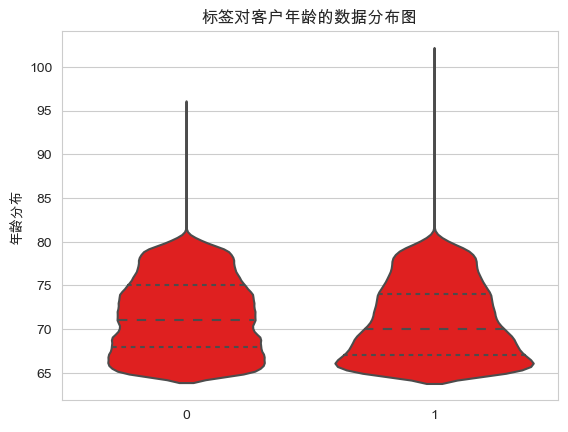

In [181]:
ax = sns.violinplot(x=insurance.resp_flag, y=insurance.age, inner='quartile', color='red')
ax.set_xlabel('')
ax.set_ylabel('年龄分布')
ax.set_title('标签对客户年龄的数据分布图')
# 年龄在65-67之间的对保险产品的响应程度更高

STEP 3, 数据类型区分 （分类型变量编码处理，数值型变量标准化处理）

In [182]:
cat_cols= data.select_dtypes(include=["object"])  

from sklearn.preprocessing import OrdinalEncoder
cat_encode= OrdinalEncoder()
cat_trans= cat_encode.fit_transform(cat_cols)
data_cat= pd.DataFrame(cat_trans, columns= cat_cols.columns)

In [183]:
num_cols= data.select_dtypes(include=["int", "float"])  

from sklearn.preprocessing import StandardScaler
num_std= StandardScaler()
num_trans= num_std.fit_transform(num_cols)
data_num= pd.DataFrame(num_trans, columns= num_cols.columns)

In [184]:
data4model= pd.concat([data_cat, data_num], axis= 1)
x = data4model
y = label

STEP 4, 分割测试集和训练集

In [185]:
from sklearn.model_selection  import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.3 , stratify=y, random_state= 666)

In [187]:
x.shape
y.shape

(43594, 49)

(43594,)

STEP 5, 建模 XGBoost

In [191]:
from xgboost.sklearn import XGBClassifier
XGB = XGBClassifier(verbosity=0)
XGB.fit(Xtrain, Ytrain)

from sklearn.metrics import classification_report
print(classification_report(Ytest, XGB.predict(Xtest)))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.68      0.81      0.74      7832
           1       0.61      0.45      0.51      5247

    accuracy                           0.66     13079
   macro avg       0.65      0.63      0.63     13079
weighted avg       0.65      0.66      0.65     13079


(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate真阳性率')

Text(0, 0.5, 'True Positive Rate伪阳性率')

Text(0.5, 1.0, 'ROC曲线图')

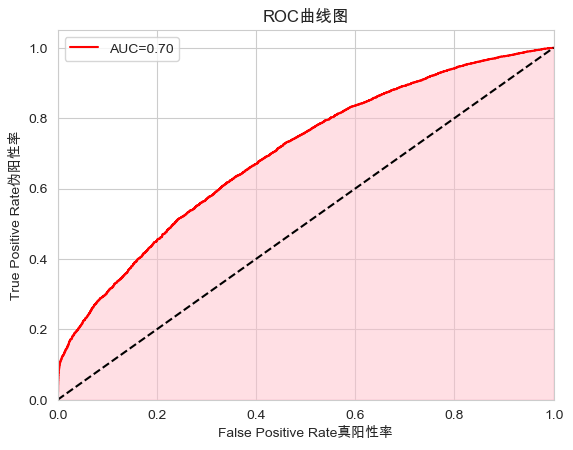

In [209]:
#看一下ROC曲线图
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_pred_proba = XGB.predict_proba(Xtest)[:,1]
fpr, tpr, thresholds = roc_curve(Ytest, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC=%0.2f'% roc_auc, color="red")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate真阳性率')
plt.ylabel('True Positive Rate伪阳性率')
plt.fill_between(fpr, tpr, alpha=0.5, color='pink')
plt.title('ROC曲线图')
plt.legend(loc="upper left")
plt.show()

In [210]:
XGB.feature_importances_

array([0.01380018, 0.01864624, 0.03101746, 0.02467132, 0.01086802,
       0.02190831, 0.0159182 , 0.02449317, 0.01687211, 0.01543502,
       0.01598791, 0.02862362, 0.01523451, 0.01481782, 0.01556956,
       0.01490923, 0.01505886, 0.02203937, 0.01393687, 0.01353731,
       0.01642288, 0.01464022, 0.01587163, 0.01674789, 0.02097085,
       0.02934882, 0.01509338, 0.01625134, 0.01737694, 0.01495771,
       0.01714079, 0.01663214, 0.01700544, 0.02852788, 0.01623819,
       0.01536404, 0.01417621, 0.03358787, 0.01602148, 0.01775903,
       0.01670134, 0.0262895 , 0.01710233, 0.01608117, 0.02624219,
       0.07627605, 0.04186902, 0.02911695, 0.01684161], dtype=float32)

In [211]:
feature_names = x.columns
sorted_importances = sorted([*zip(feature_names, XGB.feature_importances_)], key=lambda x: x[1], reverse=True)
sorted_importances

[('meda', 0.07627605),
 ('pdpe', 0.041869022),
 ('c210mys', 0.033587866),
 ('ADBT', 0.031017456),
 ('age', 0.029348819),
 ('tins', 0.029116955),
 ('BANK', 0.02862362),
 ('c210hva', 0.028527878),
 ('c210psu', 0.026289504),
 ('ilor', 0.026242191),
 ('ADEP', 0.024671316),
 ('AHRT', 0.024493167),
 ('ONLA', 0.022039372),
 ('AHCH', 0.021908311),
 ('NAH19', 0.020970851),
 ('AART', 0.01864624),
 ('c210pmr', 0.017759025),
 ('c210blu', 0.01737694),
 ('c210cip', 0.017140785),
 ('c210pwc', 0.017102333),
 ('c210hmi', 0.017005438),
 ('ADGS', 0.016872114),
 ('zhip19', 0.016841609),
 ('NOC19', 0.016747888),
 ('c210poo', 0.016701344),
 ('c210ebi', 0.01663214),
 ('SGOE', 0.01642288),
 ('c210b200', 0.016251342),
 ('c210kses', 0.01623819),
 ('c210wht', 0.016081166),
 ('c210pdv', 0.016021479),
 ('AVIS', 0.015987908),
 ('ARES', 0.015918205),
 ('SGTC', 0.01587163),
 ('INMEDI', 0.01556956),
 ('AHRL', 0.015435016),
 ('c210mah', 0.015364039),
 ('FINI', 0.015234513),
 ('c210apvt', 0.015093384),
 ('IOLP', 0.01505

<Figure size 1000x400 with 0 Axes>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [Text(0, 0, 'meda'),
  Text(1, 0, 'pdpe'),
  Text(2, 0, 'c210mys'),
  Text(3, 0, 'ADBT'),
  Text(4, 0, 'age'),
  Text(5, 0, 'tins'),
  Text(6, 0, 'BANK'),
  Text(7, 0, 'c210hva'),
  Text(8, 0, 'c210psu'),
  Text(9, 0, 'ilor'),
  Text(10, 0, 'ADEP'),
  Text(11, 0, 'AHRT'),
  Text(12, 0, 'ONLA'),
  Text(13, 0, 'AHCH'),
  Text(14, 0, 'NAH19'),
  Text(15, 0, 'AART'),
  Text(16, 0, 'c210pmr'),
  Text(17, 0, 'c210blu'),
  Text(18, 0, 'c210cip'),
  Text(19, 0, 'c210pwc'),
  Text(20, 0, 'c210hmi'),
  Text(21, 0, 'ADGS'),
  Text(22, 0, 'zhip19'),
  Text(23, 0, 'NOC19'),
  Text(24, 0, 'c210poo'),
  Text(25, 0, 'c210ebi'),
  Text(26, 0, 'SGOE'),
  Text(27, 0, 'c210b200'),
  Text(28, 0, 'c210kses'),
  Text(29, 0, 'c2

Text(0.5, 0, '特征值')

Text(0, 0.5, '特征名称')

Text(0.5, 1.0, '特征重要性排序')

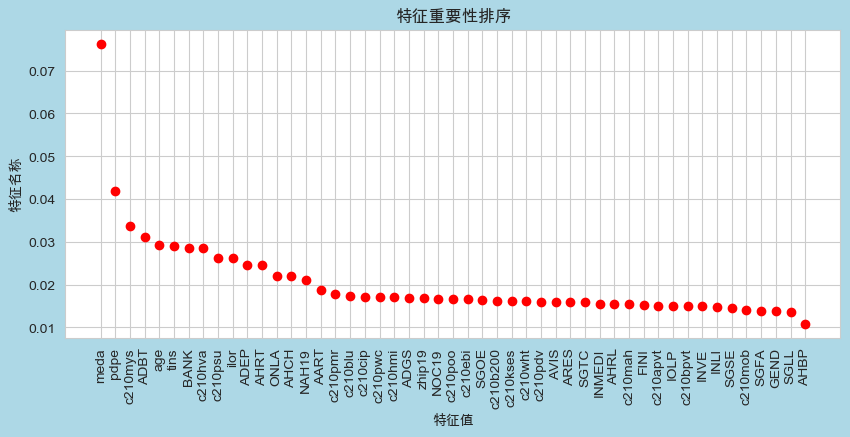

In [214]:
#看一下特征重要性的顺序
df = pd.DataFrame(sorted_importances, columns=['特征名称', '特征值'])

plt.figure(figsize=(10,4), facecolor='lightblue')
plt.scatter(df['特征名称'], df['特征值'], color="red")
plt.xticks(rotation=90) 
plt.xlabel('特征值')
plt.ylabel('特征名称')
plt.title('特征重要性排序')
plt.grid(True)
plt.show()


<Figure size 1600x400 with 0 Axes>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 [Text(0, 0, 'meda'),
  Text(1, 0, 'pdpe'),
  Text(2, 0, 'c210mys'),
  Text(3, 0, 'ADBT'),
  Text(4, 0, 'age'),
  Text(5, 0, 'tins'),
  Text(6, 0, 'BANK'),
  Text(7, 0, 'c210hva'),
  Text(8, 0, 'c210psu'),
  Text(9, 0, 'ilor'),
  Text(10, 0, 'ADEP'),
  Text(11, 0, 'AHRT'),
  Text(12, 0, 'ONLA'),
  Text(13, 0, 'AHCH'),
  Text(14, 0, 'NAH19'),
  Text(15, 0, 'AART'),
  Text(16, 0, 'c210pmr'),
  Text(17, 0, 'c210blu'),
  Text(18, 0, 'c210cip'),
  Text(19, 0, 'c210pwc'),
  Text(20, 0, 'c210hmi'),
  Text(21, 0, 'ADGS'),
  Text(22, 0, 'zhip19'),
  Text(23, 0, 'NOC19'),
  Text(24, 0, 'c210poo'),
  Text(25, 0, 'c210ebi'),
  Text(26, 0, 'SGOE'),
  Text(27, 0, 'c210b200'),
  Text(28, 0, 'c210kses'),
  Text(29, 0, 'c2

Text(0.5, 0, '特征值')

Text(0, 0.5, '特征名称')

Text(0.5, 1.0, '特征重要性排序')

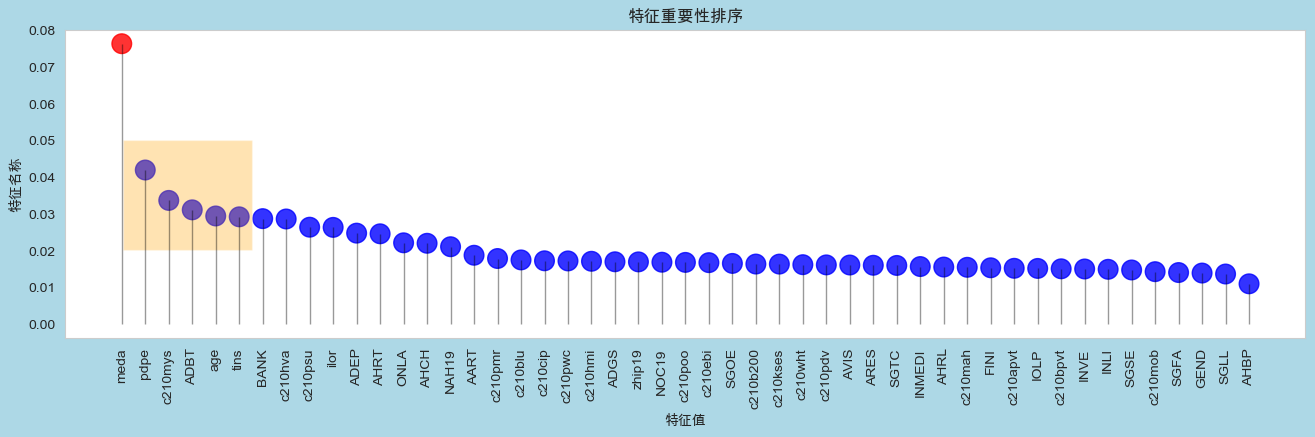

In [218]:
#勾选一下重要的几个特征，后续进一步分析
df = pd.DataFrame(sorted_importances, columns=['特征名称', '特征值'])

plt.figure(figsize=(16,4), facecolor='lightblue')

plt.vlines(x=df['特征名称'], ymin=0, ymax=df['特征值'], color='black',  alpha=0.4, linewidth=1)
plt.scatter(df['特征名称'], df['特征值'], color=["red" if i=='meda' else "blue" for i in df['特征名称']], s=200, alpha=0.8)

p1 = patches.Rectangle((0.04, 0.02),width=5.5, height=0.03,facecolor='orange',alpha=.3)
#p2 = patches.Rectangle((-2.0,-1),width=.5,height=3,facecolor='r',alpha=.3)

#将补丁添加到子图上
plt.gca().add_patch(p1)
#plt.gca().add_patch(p2);

plt.xticks(rotation=90) 
plt.xlabel('特征值')
plt.ylabel('特征名称')
plt.title('特征重要性排序')
plt.grid(False)
plt.show()

Text(0.5, 0, '')

Text(0, 0.5, '医疗覆盖率')

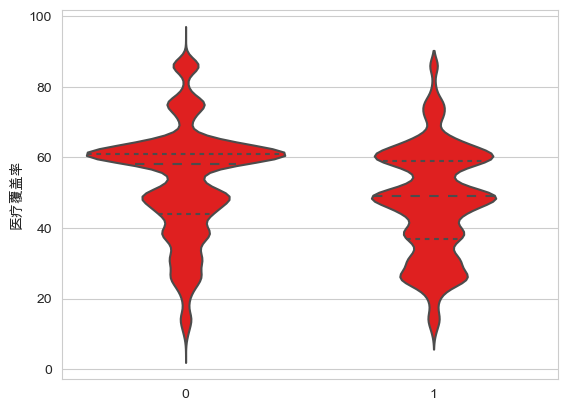

In [219]:
#医疗覆盖率达到60%的时候反而对保险产品不积极
import seaborn as sns
ax = sns.violinplot(x=insurance.resp_flag, y=insurance.meda, inner='quartile', color='red')
ax.set_xlabel('')
ax.set_ylabel('医疗覆盖率')

Text(0.5, 0, '')

Text(0, 0.5, '所在地区处方药计划覆盖比例')

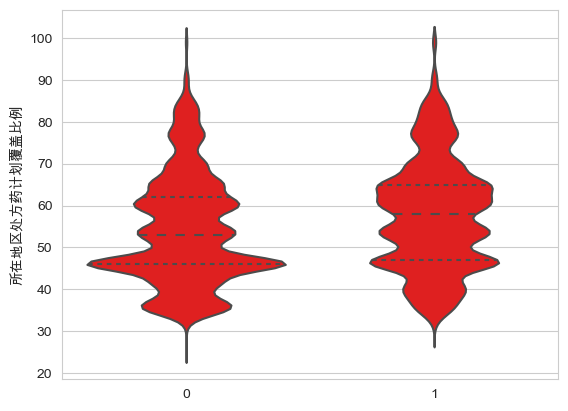

In [222]:
#处方药覆盖率在45%左右的时候对保险产品也是反馈不积极
import seaborn as sns
ax = sns.violinplot(x=insurance.resp_flag, y=insurance.pdpe, inner='quartile', color='red')
ax.set_xlabel('')
ax.set_ylabel('所在地区处方药计划覆盖比例')

分析模型的学习曲线

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, '学习曲线')

Text(0.5, 0, '训练集大小')

Text(0, 0.5, '准确率')

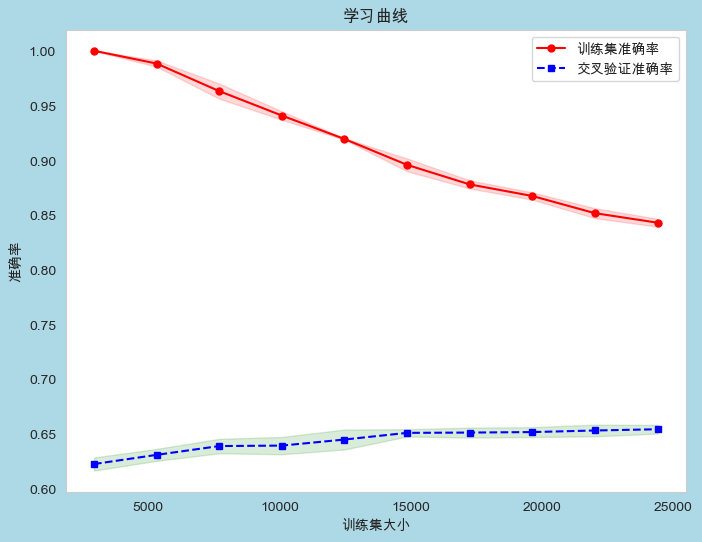

In [224]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(XGB, Xtrain, Ytrain
                                                       ,train_sizes=np.linspace(0.12, 1.0, 10), cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6), facecolor='lightblue')
plt.plot(train_sizes, train_mean, color="red", marker='o', markersize=5, label='训练集准确率')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='red')

plt.plot(train_sizes, test_mean, color="blue", linestyle="--", marker='s', markersize=5, label='交叉验证准确率')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.title('学习曲线')
plt.xlabel('训练集大小')
plt.ylabel('准确率')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


STEP 6, 更多可视化分析业务

[Text(0.5, 0, '处方药覆盖比例'), Text(0, 0.5, '医疗覆盖率')]

(array([ 20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.]),
 [Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70'),
  Text(80.0, 0, '80'),
  Text(90.0, 0, '90'),
  Text(100.0, 0, '100'),
  Text(110.0, 0, '110')])

(array([  0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100')])

Text(0.5, 1.0, '特征关系图（处方药和医疗覆盖率）')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


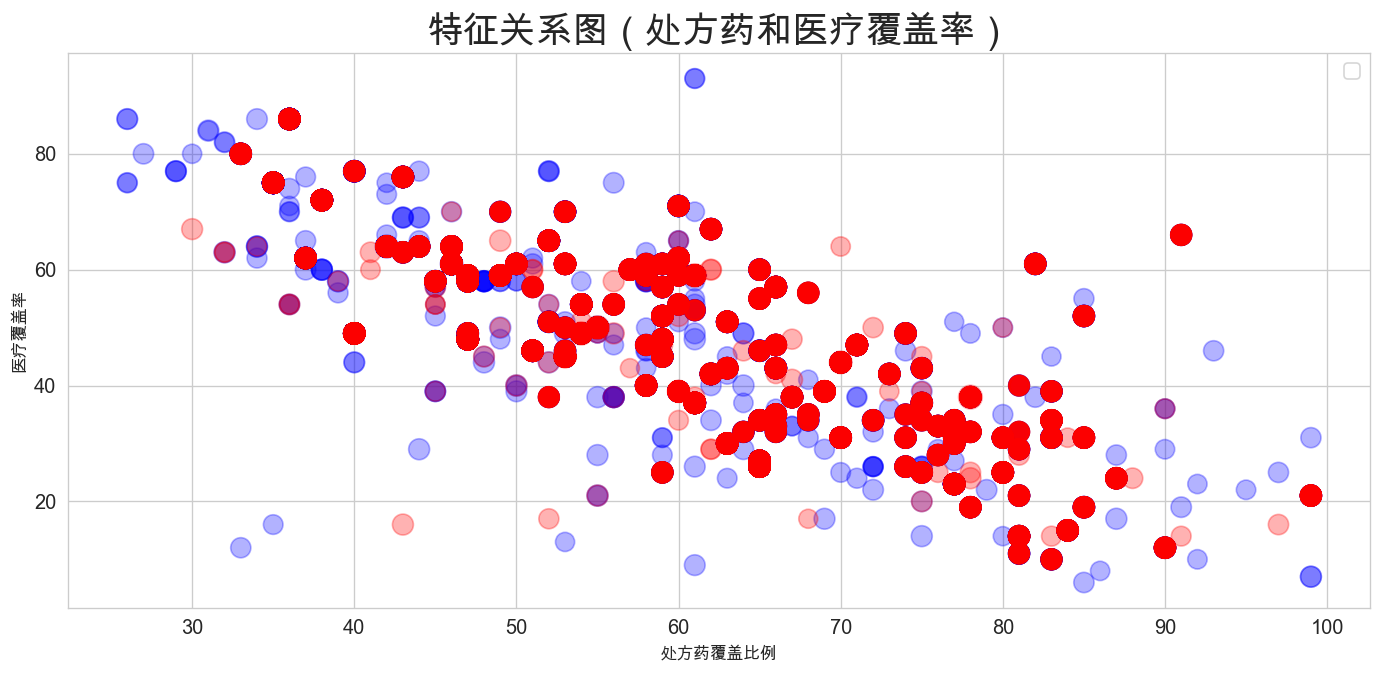

In [227]:
#分析处方药覆盖比例、医疗覆盖率、年龄和投保之间的关系 （红色为投保，蓝色为非投保）

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

colors = np.where(insurance['resp_flag']==1, 'red', 'blue')

fig = plt.figure(figsize=(14, 6), dpi=120, facecolor='w', edgecolor='k')

plt.scatter(insurance['pdpe'], insurance['meda'], 
            s=insurance['age']*2,
            alpha=0.3, color=colors)



plt.gca().set(xlabel='处方药覆盖比例', ylabel='医疗覆盖率')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("特征关系图（处方药和医疗覆盖率）", fontsize=22)
plt.legend(fontsize=12
           ,markerscale=1  
           )
plt.grid(True)
plt.show()


分享特征的相关性

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = data4model.corr()
data4model.corr(method='pearson')

,GEND,AART,ADBT,ADEP,AHBP,AHCH,ARES,AHRT,ADGS,AHRL,...,c210pmr,c210poo,c210psu,c210pwc,c210wht,ilor,meda,pdpe,tins,zhip19
GEND,1.000000,-0.060209,-0.026371,-0.027620,-0.043857,-0.040929,-0.039770,-0.010557,-0.043918,-0.009125,...,0.016826,-0.000736,0.005961,0.015863,0.004556,0.007397,0.006687,-0.009536,-0.040967,0.208045
AART,-0.060209,1.000000,0.446535,0.414836,0.633155,0.638791,0.478204,0.403336,0.670851,0.356778,...,0.050448,0.067564,0.083085,-0.029499,-0.064973,-0.062220,-0.063476,0.135485,0.212437,-0.028310
ADBT,-0.026371,0.446535,1.000000,0.306354,0.499420,0.485849,0.341365,0.360534,0.453943,0.273737,...,0.014419,0.041605,0.060485,-0.012894,-0.071841,-0.042149,-0.047009,0.102938,0.141617,-0.015765
ADEP,-0.027620,0.414836,0.306354,1.000000,0.393593,0.403531,0.379543,0.315303,0.432051,0.275775,...,0.021844,0.030693,0.045179,-0.020456,-0.053748,-0.046016,-0.031722,0.084682,0.111191,-0.018960
AHBP,-0.043857,0.633155,0.499420,0.393593,1.000000,0.719239,0.441714,0.436387,0.651853,0.348702,...,0.051210,0.075590,0.088135,-0.024968,-0.066147,-0.060504,-0.066344,0.139256,0.215897,-0.021143
AHCH,-0.040929,0.638791,0.485849,0.403531,0.719239,1.000000,0.446002,0.426195,0.690646,0.353628,...,0.077143,0.096200,0.099016,-0.034058,-0.050032,-0.065745,-0.079629,0.156065,0.240650,-0.009961
ARES,-0.039770,0.478204,0.341365,0.379543,0.441714,0.446002,1.000000,0.315271,0.483410,0.282499,...,0.021146,0.037015,0.051427,-0.019798,-0.056379,-0.049662,-0.042782,0.097107,0.135621,-0.019934
AHRT,-0.010557,0.403336,0.360534,0.315303,0.436387,0.426195,0.315271,1.000000,0.381818,0.348235,...,0.022620,0.034411,0.048184,-0.009738,-0.052884,-0.041808,-0.036291,0.092839,0.120967,-0.022923
ADGS,-0.043918,0.670851,0.453943,0.432051,0.651853,0.690646,0.483410,0.381818,1.000000,0.355565,...,0.066890,0.086048,0.096600,-0.034316,-0.065723,-0.067918,-0.072516,0.152600,0.229464,-0.004195
AHRL,-0.009125,0.356778,0.273737,0.275775,0.348702,0.353628,0.282499,0.348235,0.355565,1.000000,...,0.051474,0.050989,0.054682,-0.018147,-0.028401,-0.034645,-0.037455,0.081679,0.122330,-0.008798


<Figure size 2400x1920 with 0 Axes>

<Axes: >

Text(0.5, 1.0, '变量相关性的热力图')

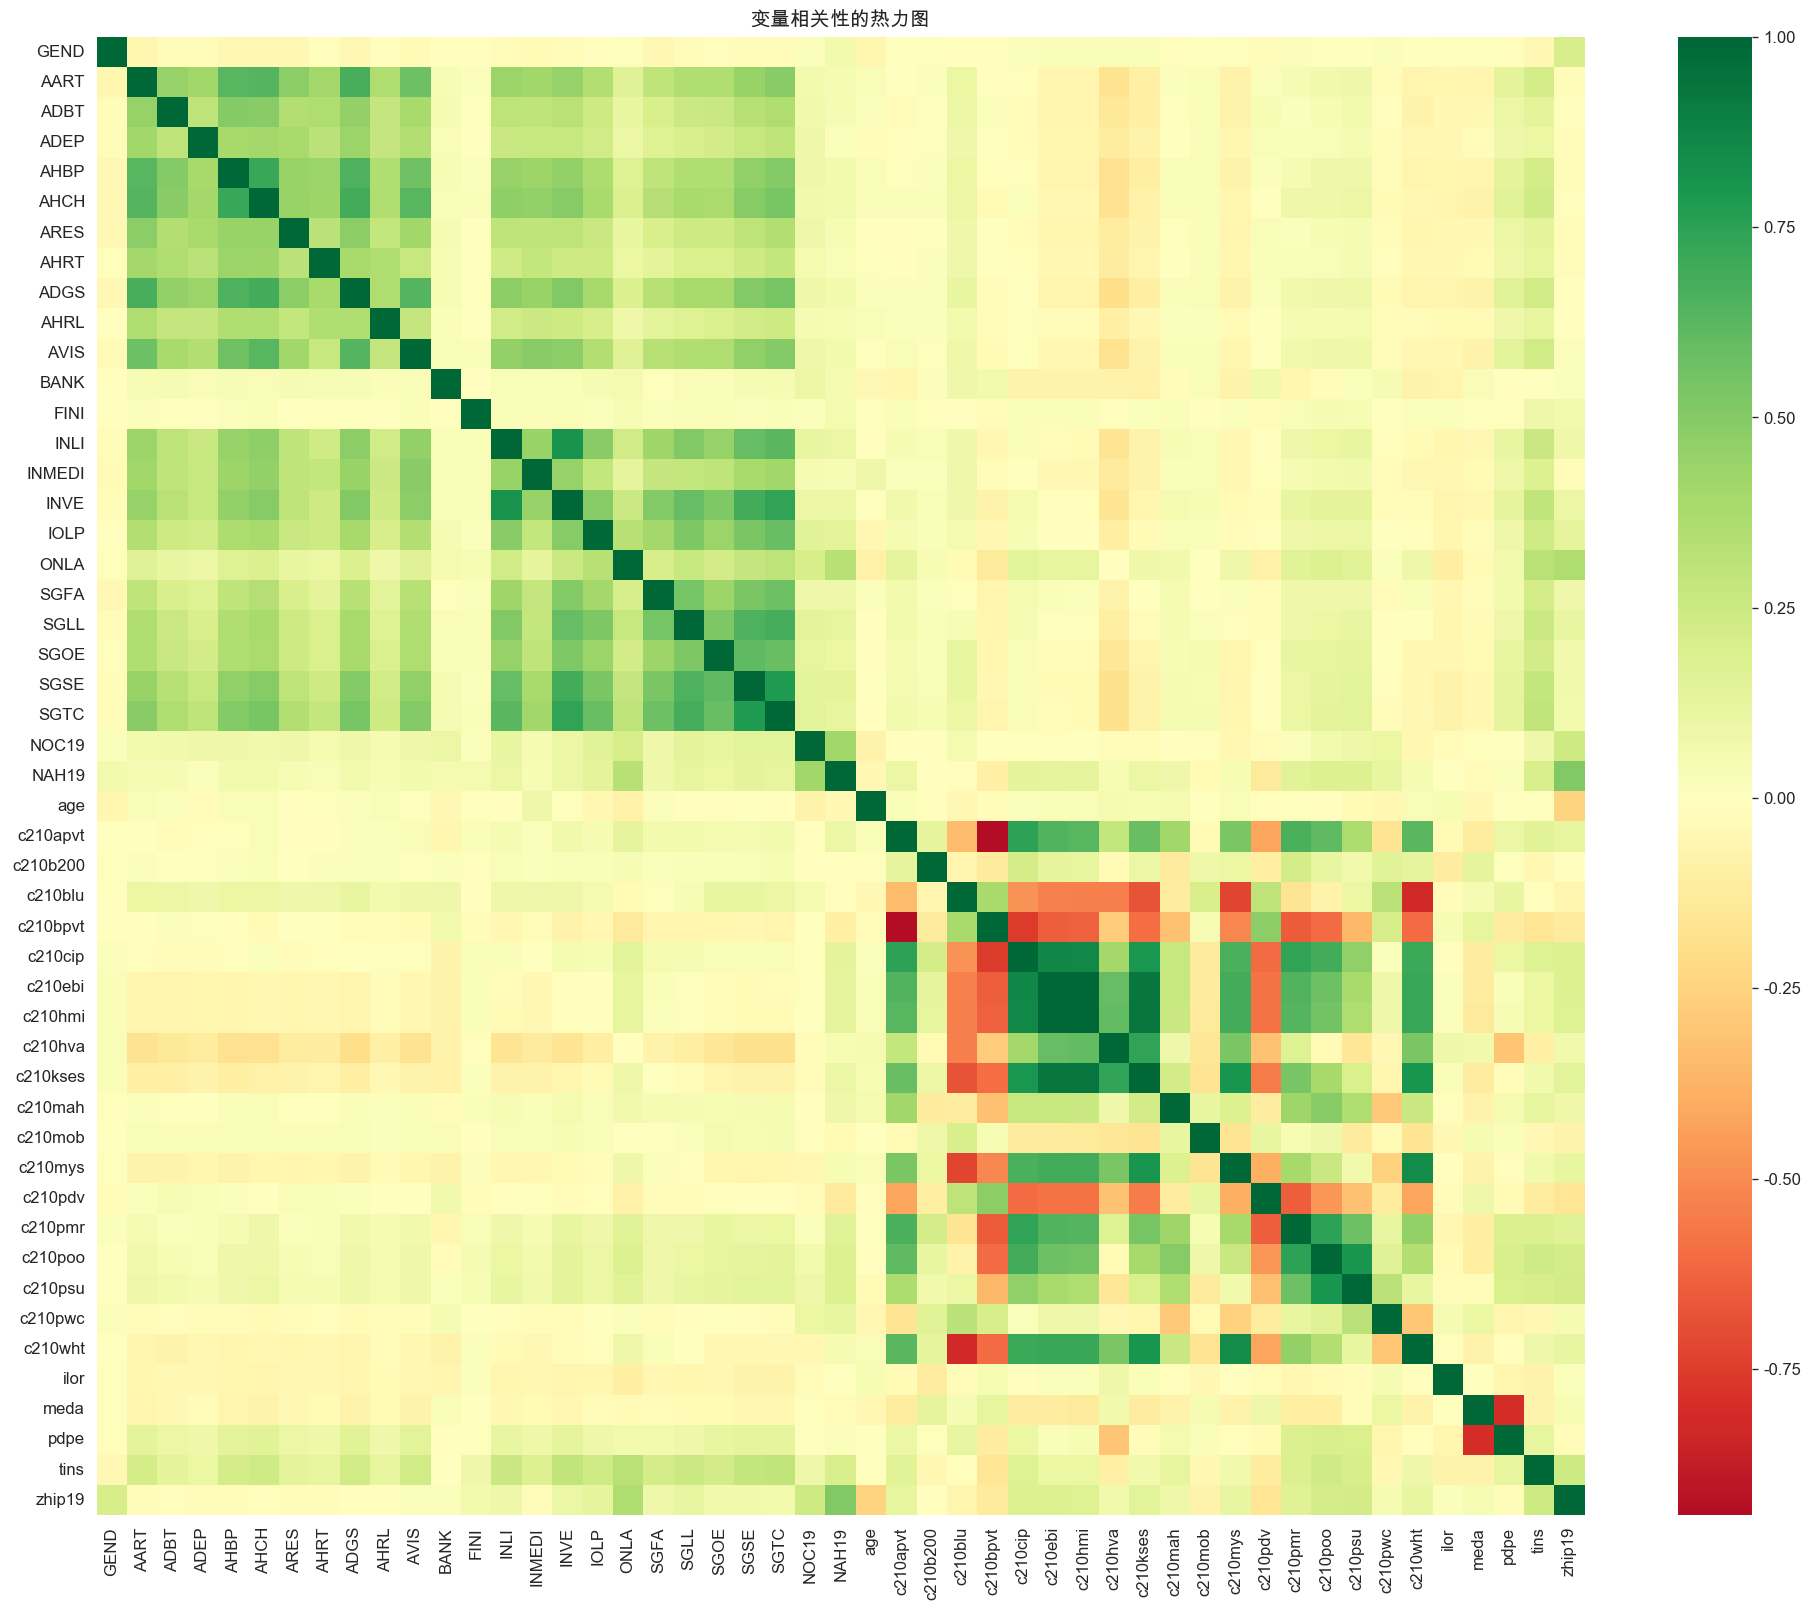

In [229]:
plt.figure(figsize=(20,16), dpi=120)
sns.heatmap(correlation_matrix
            ,annot=False   #也可以输入一个矩阵，当数字有特殊含义的时候。就是太麻烦了
            ,cmap='RdYlGn'
            ,center=0
            )
plt.title("变量相关性的热力图")
plt.show()

<Figure size 1920x1200 with 0 Axes>

(<Figure size 640x480 with 7 Axes>,
 [<Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': '重要特征的数据分布'}>])

<Figure size 1920x1200 with 0 Axes>

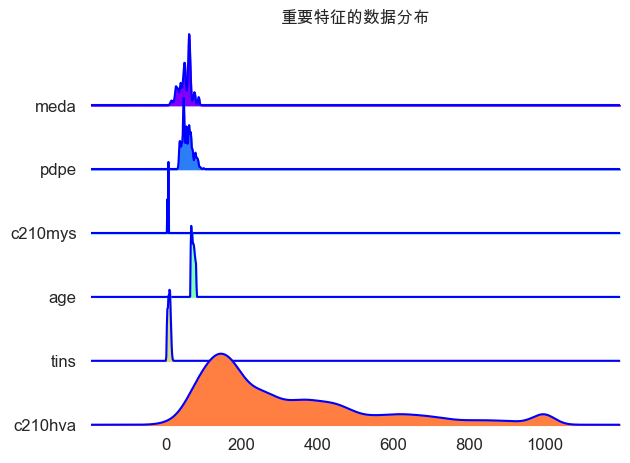

In [230]:
#看一下重要特征的数据分布
import joypy
plt.figure(figsize=(16,10),dpi=120)

joypy.joyplot(insurance
              ,column=['meda', 'pdpe', 'c210mys', 'ADBT', 'age', 'tins', 'c210hva']
              #,by="resp_flag"
              ,xlabelsize=12
              ,ylabelsize=12
              ,ylim='own'
              #,grid=True
              #,fill=False
              #,hist=True
              #,yrot=30
              #,xrot=60
              #,fade=True
              ,overlap=0.3
              ,linecolor='b'
              #,background = 'grey'
              ,title='重要特征的数据分布'
              ,colormap=plt.cm.rainbow
              )

<Figure size 480x480 with 0 Axes>

<Axes: xlabel='FINI', ylabel='age'>

Text(0.5, 1.0, '是否用过保险的年龄')

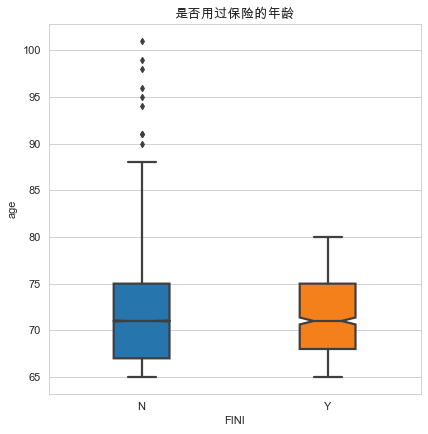

In [147]:
plt.figure(figsize=(6, 6), dpi=80)
sns.boxplot(x='FINI', y='age', data=insurance
             ,saturation=.9 
             ,width=0.3
             ,fliersize=4
             ,linewidth=2
             ,whis=1.8
             ,notch=True
            )
plt.title('是否用过保险的年龄')

<Figure size 480x480 with 0 Axes>

<Axes: xlabel='INMEDI', ylabel='age'>

Text(0.5, 1.0, '是否购买过医疗保险的年龄')

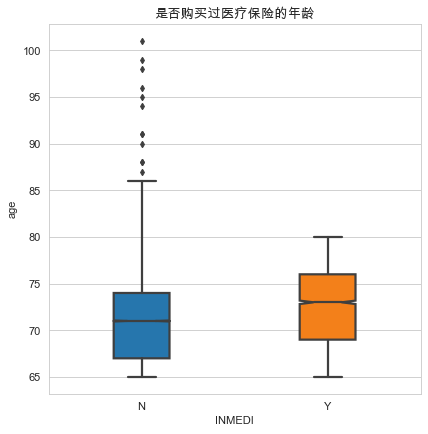

In [148]:
plt.figure(figsize=(6, 6), dpi=80)
sns.boxplot(x='INMEDI', y='age', data=insurance
             ,saturation=.9 
             ,width=0.3
             ,fliersize=4
             ,linewidth=2
             ,whis=1.8
             ,notch=True
            )
plt.title('是否购买过医疗保险的年龄')